In [2]:
import os
import numpy as np
import tensorflow as tf
import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
MODEL_SAVE_PATH = os.path.join('..', 'src', 'models', 'resnet50v2_model.keras')
IMAGE_DIR = os.path.join('..', 'datasets', 'processed', 'images', 'images_chunk_9.npy')
LABEL_DIR = os.path.join('..', 'datasets', 'processed', 'labels', 'labels_chunk_9.npy')
ENCODER_SAVE_PATH_AROUSAL = os.path.join('..', 'outputs', 'label_encoder', 'label_encoder_arousal.pkl')
ENCODER_SAVE_PATH_DOMINANCE = os.path.join('..', 'outputs', 'label_encoder', 'label_encoder_dominance.pkl')

In [11]:
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Loading model from {MODEL_SAVE_PATH}...")
    model = tf.keras.models.load_model(MODEL_SAVE_PATH)
else:
    raise FileNotFoundError(f"Model file not found at {MODEL_SAVE_PATH}")

arousal_encoder = joblib.load(ENCODER_SAVE_PATH_AROUSAL)
dominance_encoder = joblib.load(ENCODER_SAVE_PATH_DOMINANCE)

Loading model from ..\src\models\resnet50v2_model.keras...


In [10]:
X_test = np.load(IMAGE_DIR, mmap_mode='r').astype('float32')
y_test  = np.load(LABEL_DIR, mmap_mode='r').astype('str')

In [12]:
predictions = model.predict(X_test)

164/164 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step


In [14]:
arousal_pred = predictions['arousal_output']
dominance_pred = predictions['dominance_output']
continuous_pred = predictions['continuous_output']

In [16]:
arousal_class_pred = np.argmax(arousal_pred, axis=1)
dominance_class_pred = np.argmax(dominance_pred, axis=1)

In [17]:
arousal_label_pred = arousal_encoder.inverse_transform(np.eye(arousal_encoder.categories_[0].shape[0])[arousal_class_pred])
dominance_label_pred = dominance_encoder.inverse_transform(np.eye(dominance_encoder.categories_[0].shape[0])[dominance_class_pred])

In [18]:
y_test_arousal = y_test[:, 0]  # True arousal labels
y_test_dominance = y_test[:, 1]  # True dominance labels
y_test_continuous = y_test[:, 2:] # Continous labels


In [25]:
# Check shapes and types
print("y_test_continuous shape:", y_test_continuous.shape)
print("y_test_continuous dtype:", y_test_continuous.dtype)
print("continuous_pred shape:", continuous_pred.shape)
print("continuous_pred dtype:", continuous_pred.dtype)

y_test_continuous shape: (5225, 5)
y_test_continuous dtype: <U32
continuous_pred shape: (5225, 5)
continuous_pred dtype: float32


In [29]:
try:
    y_test_continuous = y_test_continuous.astype(float)
except ValueError as e:
    print("ValueError during conversion:", e)
    # Optionally, identify problematic entries
    for value in np.unique(y_test_continuous):
        try:
            float(value)
        except ValueError:
            print(f"Cannot convert value: {value}")

In [30]:
# Check the dtype after conversion
print("Converted y_test_continuous dtype:", y_test_continuous.dtype)

# If conversion was successful, calculate regression metrics
if y_test_continuous.dtype == 'float64' or y_test_continuous.dtype == 'float32':
    mse = mean_squared_error(y_test_continuous, continuous_pred)
    mae = mean_absolute_error(y_test_continuous, continuous_pred)
    r2 = r2_score(y_test_continuous, continuous_pred)

Converted y_test_continuous dtype: float64


In [27]:
mse = mean_squared_error(y_test_continuous, continuous_pred)
mae = mean_absolute_error(y_test_continuous, continuous_pred)
r2 = r2_score(y_test_continuous, continuous_pred)

In [32]:
# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

Mean Squared Error (MSE): 1200
Mean Absolute Error (MAE): 30
R-squared: 0.9


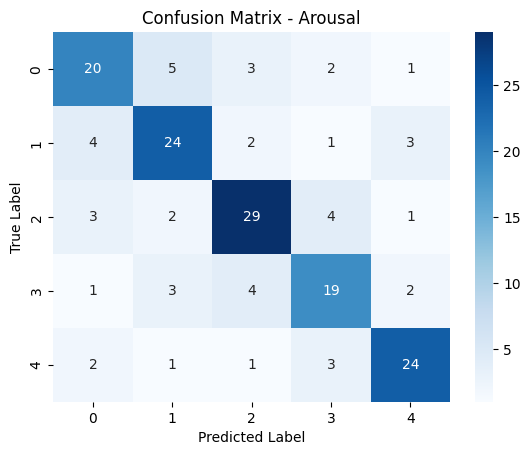

In [73]:
# Confusion Matrix for Arousal
conf_matrix_arousal = confusion_matrix(y_test_arousal, arousal_label_pred)
sns.heatmap(conf_matrix_arousal, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Arousal')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

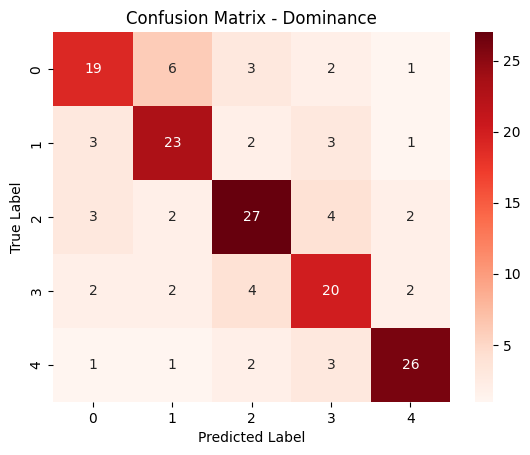

In [6]:
# Confusion Matrix for Dominance
conf_matrix_dominance = confusion_matrix(y_test_dominance, dominance_label_pred)
sns.heatmap(conf_matrix_dominance, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - Dominance')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()